## Sandox for Developing Resnet
Notes, ideas, and general approach to building Resnet from the ground up.

## General Approach

fastai for data handling and training, pytorch for architecure. 

1. Use fast.ai for downloading data / preprocessing / loading / augmentations etc.
- Unroll and practice NN building and training loops
- Create a basic neural network to run through MNIST using pytorch
- Create a better neural network with multiple layers and convolutions in pytorch
- Download CIFAR
- Create VGG
- Create ResNet
- Create wide ResNet 
- Download COCO
- Try training only on COCO
- Try training on CIFAR, then COCO
- Try making final Detectron Wide Resnet using  
- pretrain on imagenet, then COCO 
- Clean up and put into module for use as backbone retinanet
- Do a short write up of experience

In [56]:
from fastai.vision import *
from fastai.datasets import *
from dataclasses import dataclass

## MNIST

In [57]:
path = untar_data(URLs.MNIST_SAMPLE)
path

PosixPath('/home/sudosharma/.fastai/data/mnist_sample')

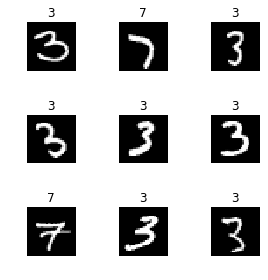

In [58]:
data = ImageDataBunch.from_folder(path)
data.show_batch(rows=3, figsize=(4, 4))

## NN v1

In [59]:
model = simple_cnn((3, 16, 16, 2))
learn = Learner(data, model, metrics=accuracy)
learn.fit(1)

epoch,train_loss,valid_loss,accuracy,time
1,0.129224,0.107997,0.967125,00:00


## NN v2

In [60]:
model = models.resnet50
learn = create_cnn(data, model, metrics=accuracy)
learn.fit(1)

epoch,train_loss,valid_loss,accuracy,time
1,0.131169,0.062795,0.976938,00:04


## NN v3

In [61]:
@dataclass
class PrintOutput(LearnerCallback):
    """Function to figure out if fastai is modifying final tensor before loss_func."""
    learn: Learner

    def on_loss_begin(self, **kwargs):
        if kwargs['num_batch'] == 1: print(kwargs['last_output'].shape)
        return kwargs['last_output']

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)

In [62]:
model = nn.Sequential(
    Flatten(),
    nn.Linear(3*28*28, 50), nn.ReLU(True),
    nn.Linear(50, 50)
)
learn = Learner(data, model, metrics=accuracy)
cb = PrintOutput(learn)
learn.fit(1, callbacks=[cb])

epoch,train_loss,valid_loss,accuracy,time
1,0.050356,0.082000,0.975957,00:00


torch.Size([64, 50])


## NN v4

In [96]:
model = nn.Sequential(
    nn.Conv2d(3, 256, 3, 1), nn.ReLU(True),
    nn.Conv2d(256, 128, 3, 1), nn.ReLU(True),
    nn.Conv2d(128, 64, 3, 1), nn.ReLU(True),
    nn.AdaptiveMaxPool2d(1),
    Flatten()
)
learn = Learner(data, model, metrics=accuracy)
learn.fit(1)

epoch,train_loss,valid_loss,accuracy,time
1,0.125952,0.093757,0.966634,00:01


## NN v5

In [97]:
def conv(ni, nf, k, actn=False):
    """A conv layer module."""
    layers = [nn.Conv2d(ni, nf, k, k//2)]
    layers += [nn.ReLU(True)] if actn else []
    return nn.Sequential(*layers)

class SimpleCNN(nn.Module):
    """A convnet block using module list approach."""
    def __init__(self, *cs):
        super().__init__()
        self.layers = nn.ModuleList(
            [conv(cs[i], cs[i+1], 3, True) for i in range(len(cs)-1)])
        self.layers.extend([nn.AdaptiveMaxPool2d(1), Flatten()])
        
    def forward(self, x):
        for l in self.layers:
            x = l(x)
        return x

model = SimpleCNN(3, 256, 128, 64)
learn = Learner(data, model, metrics=accuracy)
learn.fit(1)

epoch,train_loss,valid_loss,accuracy,time
1,0.125435,0.091331,0.968106,00:01


## ImageNet

## NN v6